https://flopy.readthedocs.io/en/3.3.2/_notebooks/tutorial01_mf6.html

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp
import os
import platform
import subprocess

from shapely.geometry import Polygon, Point

In [2]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import os
from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
import numpy as np

In [3]:

def change_array_within_polygon(array, row_coords, col_coords, value):

    # Create a polygon object from the row and column coordinates
    polygon = Polygon(zip(col_coords, row_coords))

    # Create a boolean mask indicating which points fall within the polygon
    mask = np.zeros_like(array, dtype=bool)
    for row in range(array.shape[0]):
        for col in range(array.shape[1]):
            point = Point(col, row)
            if polygon.contains(point) or polygon.intersects(point):
                mask[row, col] = True

    # Set the values of the array that fall within the polygon to the new value
    array[mask] = value

    return array


In [4]:
def locate_ground_surface_lay(row=150):
    cross_section = ibound[:,:,0]
    lay = np.where(cross_section[:,row]==1)[0][0]
    return lay

def meter_to_col(col_meter):
    return int(np.round(col_meter/delc,0))

def meter_to_row(row_meter):
    return int(np.round(row_meter/delc,0))

def meter_to_lay(lay_meter):
    return int(np.round((top_elev-lay_meter)/layer_thickness,0))


def col_to_meter(col):
    return col*delc

def row_to_meter(row):
    return row*delc

def lay_to_meter(row):
    return 190.0-row*layer_thickness

# Workspace

In [5]:
myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')
model_ws = temp_dir


def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

In [613]:
# name = "wasaga_mf6"
# h1 = 100
# h2 = 90
# Nlay = 120
# N = 440

# L = 400.0
# H = 50.0
# k = 1.0

In [6]:
name = "wasaga_mf6"

# Define model dimensions
nlay = int(60*1)
nrow = int(220*2)
ncol = int(220*2)
delr = 2200/nrow  # Cell width along rows (extend 2200 / 220)
delc = 2200/ncol  # Cell width along columns (extend 2200 / 220)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 30.0 / nlay

perlen = 365
nper = int(1)
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))
#steady=[False,False,True]

# SIM

In [29]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=model_ws)

# TDIS

In [30]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(365.0, 1, 1.0)])

#perioddata ([perlen, nstp, tsmult])

# IMS

In [31]:
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="MODERATE") # Iterative Model Solution

# GWF

In [32]:
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [33]:
# bot = np.linspace(-H / Nlay, -H, Nlay)
# delrow = delcol = L / (N - 1)
# dis = flopy.mf6.ModflowGwfdis(
#     gwf,
#     nlay=Nlay,
#     nrow=N,
#     ncol=N,
#     delr=delrow,
#     delc=delcol,
#     top=0.0,
#     botm=bot,
# )

In [34]:
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    pname="sto",
    save_flows=True,
    ss=0.002,
    sy=0.33,
    steady_state={0: True}
)

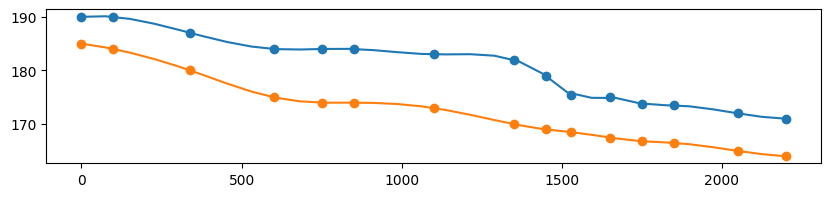

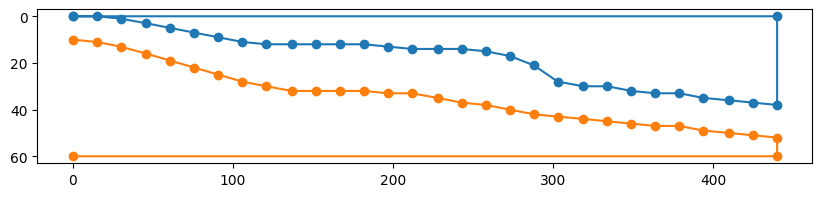

In [35]:
from scipy.interpolate import make_interp_spline

x = np.array([0, 100, 340, 600, 750, 850, 1100, 1350, 1450, 1530, 1650, 1750, 1850, 2050, 2200])
y_topo = np.array([190,190,187,184,184,184,183,182,179,175.5,175,173.8,173.5,172,171])#topo
y_clay = np.array([185,184,180,175,174,174,173,170,169,168.5,167.5,166.8,166.5,165,164]) #clay



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]




plt.scatter(x, y_topo)
plt.plot(x_smooth_topo, y_smooth_topo)

# Plot the original data and the smooth curve
plt.scatter(x, y_clay)
plt.plot(x_smooth, y_smooth)


plt.gcf().set_size_inches(10,2)
# Show the plot
plt.show()


plt.plot(col_coords_topo,row_coords_topo)
plt.scatter(col_coords_topo,row_coords_topo)

plt.plot(col_coords_clay,row_coords_clay)
plt.scatter(col_coords_clay,row_coords_clay)

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,2)

185.5
186.0
186.5


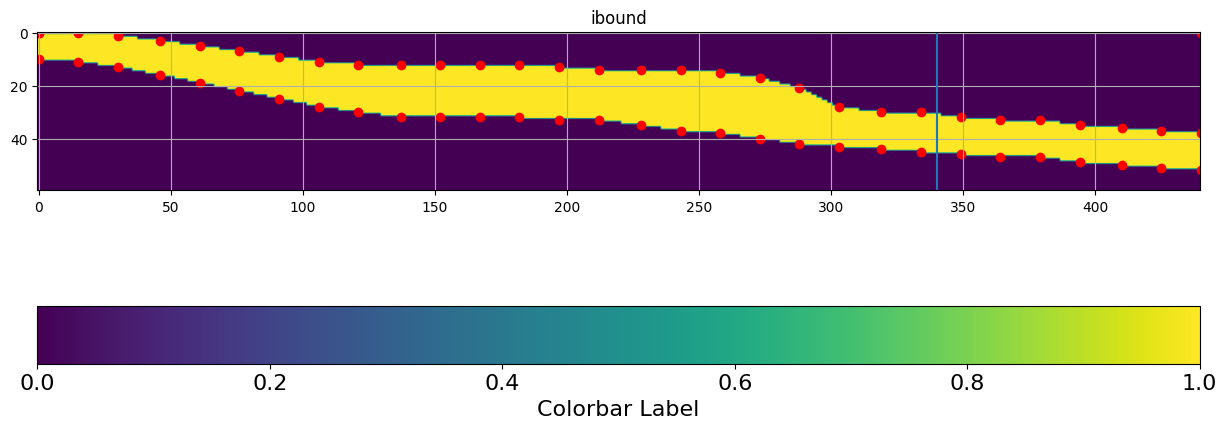

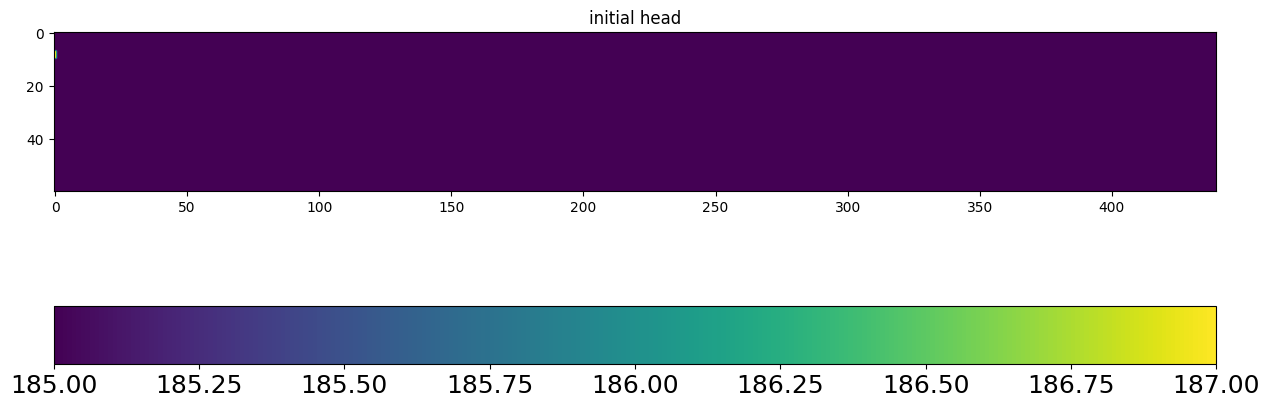

In [41]:

# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)
initial_head = np.full((nlay, nrow, ncol), 185.0, dtype=float)

# Set constant head boundary conditions for the first and last rows
array = change_array_within_polygon(ibound, row_coords_topo, col_coords_topo, 0)
plt.scatter(col_coords_topo,row_coords_topo,c='r')


array = change_array_within_polygon(ibound, row_coords_clay, col_coords_clay, 0)
plt.scatter(col_coords,row_coords,c='r')



ibound_2 = ibound.copy()
for c in range(0,1):
    i = np.where(ibound[:,c,-1]==1)[0][-1]
    head = top_elev-i*layer_thickness
    #print('head {}'.format(head))
    
    while head<187:
        ibound_2[i,c,:] = 2
        #print(i,c)
        #initial_head[i,c,:] = head+0.5
        print(head)
        initial_head[i,c,:] = 187
        head+=layer_thickness
        i-=1


lay = np.where(ibound[:,int(1700/delr),-1])[0][0]
elv = lay_to_meter(lay)
head = elv
for c in range(int(1700/delr),int(2200/delr)):
    lay = np.where(ibound[:,c,-1]==1)[0][0]
    #print(lay,lay_to_meter(lay))
    #ibound[lay,c,:] = -1
    #initial_head[lay,c,:] = elv

# Your existing code
im = plt.imshow(ibound[:,:,2], origin='upper', aspect=1)
plt.axvline(x=meter_to_col(1700))# shoreline
plt.gcf().set_size_inches(15,10)

# Set the y-axis tick positions and labels
#plt.yticks([0, 10,20, 30,40, 50,60], ['190m (0L)','185m (10L)', '180m (20L)','175m (30L)', '170m (40L)', '165m (50L)','160m (60L)'])

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Colorbar Label', fontsize=16)

# Display the plot
plt.title('ibound')
plt.grid()
plt.show()


fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(initial_head[:, :, 0], origin='upper')

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
plt.title('initial head')
plt.show()



# DIS

In [37]:
#ibound = np.ones((nlay, nrow, ncol), dtype=int)

In [43]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=190.0,
    botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
    idomain=ibound
)

# IC

In [44]:
#start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=191)

In [55]:
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=6.9, save_flows=True)

# CHD

In [46]:
# N = 220
# Nlay =60
# h1 = 100
# h2 =90
# chd_rec = []
# chd_rec.append(((0, int(N / 4), int(N / 4)), h2))
# for layer in range(0, Nlay):
#     for row_col in range(0, N):
#         chd_rec.append(((layer, row_col, 0), h1))
#         chd_rec.append(((layer, row_col, N - 1), h1))
#         if row_col != 0 and row_col != N - 1:
#             chd_rec.append(((layer, 0, row_col), h1))
#             chd_rec.append(((layer, N - 1, row_col), h1))

In [47]:
# cellids = np.array([np.where(ibound_2==2)])[0].T
# chd_rec = {}
# chd_rec[0] = [(tuple(i),187)for i in cellids]

In [48]:
lays = np.where(ibound[:,0,0]==1)[0]
chd_rec = [] 
for lay in lays:
    for row in [0]:
        for col in range(nrow):
            chd_rec.append(((lay,row,col),190))




lays = np.where(ibound[:,-1,0]==1)[0]

for lay in lays:
    for row in [nrow-1]:
        for col in range(nrow):
            chd_rec.append(((lay,row,col),175.0))


stress_period_data = chd_rec


In [49]:
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=stress_period_data,
)

In [50]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((1, 0, 0), 190.), ((1, 0, 1), 190.), ((1, 0, 2), 190.), ...,
           ((51, 439, 437), 175.), ((51, 439, 438), 175.),
           ((51, 439, 439), 175.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

In [51]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [52]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model wasaga_mf6...
    writing model name file...
    writing package sto...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 10120 based on size of stress_period_data
    writing package oc...


In [53]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\mf6.EXE


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Apr 12 2023 19:05:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauth

Exception: MODFLOW 6 did not terminate normally.

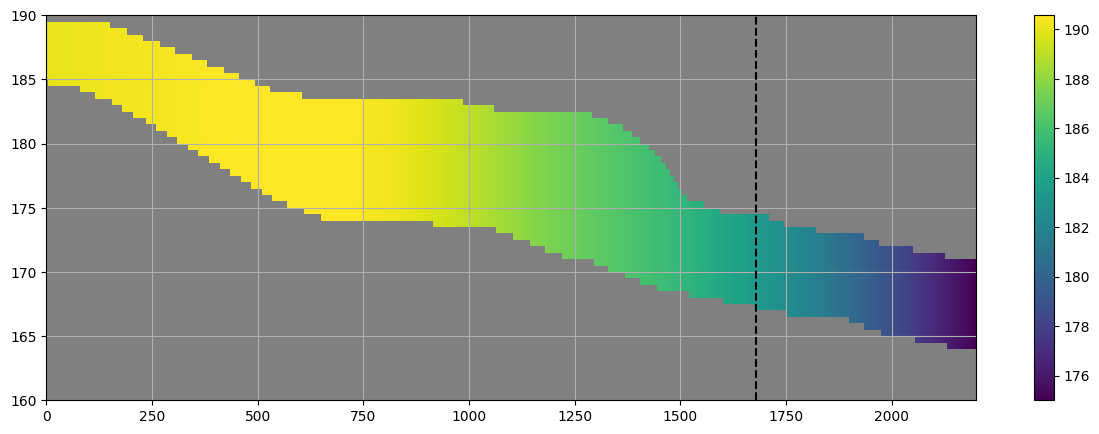

In [ ]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=gwf, line={"Column": 100})



hds = flopy.utils.binaryfile.HeadFile(model_ws+ '/'+headfile)
head_data = hds.get_data(kstpkper=(0, 0)) # (time step, stress period)
masked_head_data = np.ma.masked_where(ibound<= 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="viridis")
plt.colorbar(cs)


plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
#ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1680, color='black', linestyle='--')

#plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
#xs = drn_ys
#ys = [ lay_to_meter(locate_ground_surface_lay(meter_to_row(y))) for y in drn_ys]
#plt.scatter([x - 0.0 for x in xs],[y- 0.0 for y in ys],c='r',marker='s',s=5)

plt.show()

TypeError: Length of x (220) must match number of columns in z (440)

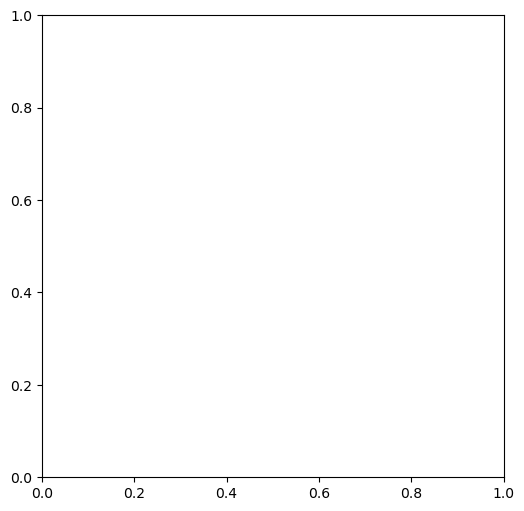

In [355]:
hds = flopy.utils.binaryfile.HeadFile(model_ws+ '/'+headfile)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, 2200, 220)
y = y[::-1]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], np.arange(90, 100.1, 0.2), colors="black")
plt.clabel(c, fmt="%2.1f")

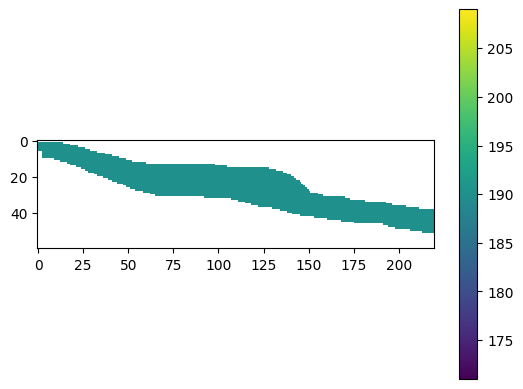